<a href="https://colab.research.google.com/github/karsarobert/NLP_2024/blob/main/04/NLP2024_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Természetes nyelvfeldolgozás
# PTE Gépi tanulás III.

## 1. Előadás: BERT, finomhangolás
### 2024. február 28.


![img](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Full_GPT_architecture.png/800px-Full_GPT_architecture.png)

![img](https://sebastianraschka.com/images/blog/2023/llm-reading-list/transformer.png)

## A Transformer modell működése

Bal oldalon a bemenetek a transzformátor kódoló oldalára kerülnek egy figyelem alrétegen és egy továbbítási alrétegen keresztül. Jobb oldalon a célkimenetek a transzformátor dekóder oldalára kerülnek két figyelem alrétegen és egy továbbítási hálózati alrétegen keresztül. Rögtön látható, hogy nincs RNN, LSTM vagy CNN. Ennek az az oka, hogy ebben az architektúrában elhagyták a **rekurrenciát**.

A figyelem helyettesítette a rekurrencia funkciókat, amelyek egyre növekvő paramétereket igényelnek, ahogy nő a két szó közötti távolság. A figyelemmechanizmus egy "szó-szó" művelet. Valójában egy token-token művelet, de a magyarázat egyszerűsítése érdekében maradunk a szó szintjén. A **figyelemmechanizmus megtalálja, hogy az egyes szavak hogyan kapcsolódnak a szekvencia összes többi szavához**, beleértve magát az elemzett szót is. Például vizsgáljuk meg a következő szekvenciát:

The cat sat on the mat.

A figyelem **mátrixműveleteket** fog futtatni a szavvektorok között, és meghatározza egy szó legerősebb kapcsolatait az összes többi szóval, beleértve önmagát is ("macska" és "macska"):

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file19.png)


A figyelemmechanizmus mélyebb kapcsolatot biztosít a szavak között, és jobb eredményeket produkál. Minden figyelem alréteg esetében az eredeti Transformer modell **nem egy, hanem nyolc figyelemmechanizmust futtat párhuzamosan** a számítások felgyorsítása érdekében. Ezt az architektúrát a következő részben, a Kódoló stackban fogjuk vizsgálni. Ez a folyamat a "többfejű figyelem" nevet kapta, amely a következőket biztosítja:

* Szélesebb, mélyebb elemzés a szekvenciákról
* A rekurrencia elhagyása csökkenti a számítási műveleteket
* **Párhuzamosítás bevezetése**, ami csökkenti a betanítási időt
* Mindegyik figyelemmechanizmus a bemeneti szekvencia **eltérő nézőpont**jait tanulja meg



## A kódoló stack

Az eredeti Transformer modell kódolójának és dekódolójának több rétege van. A kódoló stack minden egyes rétege a következő szerkezettel rendelkezik:

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file20.png)

Az eredeti kódolóréteg-struktúra megegyezik a Transformer modell N=6 minden rétegénél. Minden réteg két fő alréteget tartalmaz: egy többfejű figyelemmechanizmust és egy teljesen összekapcsolt feedforward hálózatot.

Bár a kódoló N=6 rétegének szerkezete megegyezik, az egyes rétegek tartalma nem teljesen azonos az előző réteggel az egyes rétegek eltérő súlyai miatt.

Például a **beágyazási alréteg csak a stack alsó szintjén van** jelen. A másik öt réteg nem tartalmaz beágyazási réteget.

Ezenkívül a többfejű figyelemmechanizmusok az 1-től 6-ig terjedő rétegekben ugyanazokat a funkciókat látják el. Azonban nem ugyanazokat a feladatokat hajtják végre. **Minden réteg tanul az előző rétegből**, és különböző módokat fedez fel a szekvenciában lévő tokenek társítására. A szavak különböző társításait keresi, akárcsak mi, amikor rejtvényt fejtünk, és különböző betű- és szótársításokat keresünk.

A Transformer tervezői egy nagyon hatékony korlátot vezettek be. **A modell minden alrétegének kimenete állandó dimenziójú**, beleértve a beágyazási réteget és a residuális kapcsolatokat is. Ez a dimenzió dmodel. Az eredeti Transformer architektúrában dmodel = 512.

A dmodel-nek következménye van. Gyakorlatilag az összes kulcsfontosságú művelet mátrixszorzás. Ennek eredményeként a dimenziók stabilak maradnak.

Az kódolónak ez a globális nézete a Transformer erősen optimalizált architektúráját mutatja. A következő részekben minden egyes alréteget és mechanizmust részletesebben megvizsgálunk.

A beágyazási alréteggel kezdjük.

## Bemenet beágyazása

A bemenet beágyazási alrétege a bemeneti tokeneket dmodel = 512 dimenziójú vektorokká alakítja az eredeti Transformer modellben tanult beágyazások segítségével. A bemenet ágyazásának szerkezete klasszikus:

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file21.png)


[A bemenet tokenekre bontása](https://platform.openai.com/tokenizer)

## Bemenet beágyazása

A beágyazási alréteg más szabványos transzdukciós modellekhez hasonlóan működik. Egy tokenizáló átalakítja a mondatot tokenekké. Minden tokenizálónak megvannak a maga módszerei, például a **Byte Pair Encoding (BPE) ezt az OpenAi fejlesztette ki**, a word piece és a sentence piece módszerek. A Transformer eredetileg BPE-t használt, de más modellek más módszereket is alkalmaznak.

A célok hasonlóak, és a választás a választott stratégiától függ. Például egy tokenizáló a "the Transformer is an innovative NLP model!" sorozatra alkalmazva ilyen tokeneket fog előállítani egy adott modellben:

['the', 'transform', 'er', 'is', 'an', 'innovative', 'n', 'l', 'p', 'model', '!']

Látható, hogy ez a tokenizáló kisbetűre konvertálta a sztringet és részekre bontotta. Egy tokenizáló általában egy egész számos reprezentációt biztosít, amelyet az ágyazási folyamat során használnak. Például:

szöveg = "The cat slept on the couch.It was too tired to get up."
tokenizált szöveg = [1996, 4937, 7771, 2006, 1996, 6411, 1012, 2009, 2001, 2205, 5458, 2000, 2131, 2039, 1012]

Ebben a pillanatban még nem áll rendelkezésre elegendő információ a tokenizált szöveg alapján a folytatáshoz. A tokenizált szöveget be kell ágyazni.

A Transformer tartalmaz **egy tanult beágyazási alréteget.** Ennek eredményeként számos beágyazási módszer alkalmazható a tokenizált bemenetre.

A Transformer beágyazási alrétegének illusztrálására a Google által 2013-ban közzétett word2vec beágyazási megközelítés skip-gram architektúráját nézzük meg. A skip-gram a szavak ablakában lévő középső szóra fog összpontosítani és összefüggésbeli szavakat jósol.

![img](https://miro.medium.com/v2/resize:fit:1400/0*yxs3JKs5bKc4c_i8.png)

![img](https://miro.medium.com/v2/resize:fit:1400/1*cuOmGT7NevP9oJFJfVpRKA.png)

Például, ha a word(i) a középső szó egy kétlépéses ablakban, akkor a skip-gram modell a word(i-2), word(i-1), word(i+1) és word(i+2) szavakat fogja elemezni. Ezután az ablak eltolódik, és a folyamat megismétlődik. Egy skip-gram modell általában tartalmaz egy bemeneti réteget, súlyokat, egy rejtett réteget és egy kimenetet, amely a tokenizált bemeneti szavak szóbeágyazásait tartalmazza.

Tegyük fel, hogy a következő mondathoz kell beágyazást végezni:

The black cat sat on the couch and the brown dog slept on the rug.

Két szóra, a "black" és a "brown" szóra fogunk összpontosítani. Ezeknek a szavaknak a szóbeágyazási vektorai hasonlóak kell legyenek.

Mivel minden szóhoz dmodel = 512 méretű vektort kell előállítanunk, minden szóhoz egy 512 méretű vektorbeágyazást kapunk:



In [ ]:
import gensim.downloader as api
from gensim.models import KeyedVectors

# Betöltjük a Word2Vec modellt (egy lehetséges példa)
model = api.load("glove-twitter-50")

# Beágyazzuk a  "black" és "brown" szavakat
black_embedding = model["black"]

print(black_embedding)


brown_embedding = model["brown"]

print(brown_embedding)

# Kiszámítjuk a koszinusz hasonlóságot
cos_similarity = model.similarity("black", "brown")

# Kiírjuk a koszinusz hasonlóságot
print(f"A koszinusz hasonlóság a 'black' és 'brown' szavak között: {cos_similarity}")


[-0.51215  -1.1742    0.13109   0.46333  -0.21871   0.050836  0.82754
  0.4693    0.55392   0.20517  -0.64789   0.80742  -4.4013    0.15611
  0.15493  -0.28418  -0.21243  -0.23844   0.4897    0.63654  -1.2064
 -0.26957   0.75382  -1.5142    0.37308  -0.34848  -0.68356   0.30585
 -0.034706 -0.37222   0.061295  0.27606   0.28115  -0.43192   0.40879
 -0.21589  -0.27238  -0.23725   0.011904 -0.39408  -1.6278   -0.021993
 -0.12557   0.17991   0.17847  -0.55538   0.66707   0.38752  -0.14439
 -0.17894 ]
[-6.4007e-01 -1.7615e+00  6.4874e-01  3.7342e-02 -1.4549e-01 -1.5672e-01
  8.4636e-01  4.6387e-01 -1.6172e-01 -2.5805e-01 -6.8369e-02  2.5422e-01
 -3.5850e+00 -7.2949e-01  2.3258e-01 -1.9458e-01 -4.2143e-01  8.0162e-04
  2.5699e-01  7.5122e-02 -3.4076e-01  1.2274e-01  2.7698e-01 -1.3465e+00
  6.1301e-01 -2.5346e-01  6.6083e-02  4.9287e-01 -3.7427e-01 -6.0144e-01
  1.5865e-01  8.7051e-01 -1.0704e+00 -3.2066e-01 -4.2425e-01  3.3071e-01
 -8.8770e-02 -2.2529e-01  2.5774e-01  1.1681e-01 -1.2520e+00

##A macskaszó beágyazása
1. Állat: A macska egy emlősállat, a ragadozók rendjébe tartozik.
2. Háziállat: A macskát gyakran tartják háziállatként a társaság és a szórakozás kedvéért.
3. Független: A macskák általában független állatok, kevésbé igénylik az emberi figyelmet, mint a kutyák.
4. Ragadozó: A macskák természetes ragadozók, kisebb emlősökre és madarakra vadásznak.
5. Játékos: A macskák szeretnek játszani, és ehhez különféle tárgyakat, játékokat használnak.
6. Kíváncsi: A macskák kíváncsi természetűek, és szeretik felfedezni a környezetüket.
7. Tiszta: A macskák tisztaságkedvelő állatok, és sok időt töltenek a bundájuk tisztításával.
8. Ügyes: A macskák ügyesek és mozgékonyak, képesek ugrásra, mászásra és egyensúlyozásra.
9. Kedves: A macskák lehetnek kedvesek és ragaszkodóak az emberi gazdáikhoz.
10. Titokzatos: A macskák néha titokzatosnak és kiszámíthatatlannak tűnnek, ami hozzájárul a varázsukhoz.
...


![img](https://www.tyrrell4innovation.ca/wp-content/uploads/2021/06/rsz_jenny_du_miword.png)

A skip-gram modell két olyan vektort hozott létre, amelyek közel állnak egymáshoz. Felismerte, hogy a "fekete" és a "barna" szavak a szavak szótárának egy szín alhalmazát alkotják. A Transformer későbbi rétegei nem üres kézzel kezdik a munkát. Ehelyett tanult szóbeágyazásokkal rendelkeznek, amelyek már információt szolgáltatnak arról, hogyan lehet a szavakat asszociálni.

Azonban egy jelentős információ hiányzik, mivel nincs további vektor vagy információ, amely egy szó helyzetét jelzi a sorozatban. A Transformer tervezői egy újabb innovatív funkcióval álltak elő: a pozíciókódolással.

Lássuk, hogyan működik a pozíciókódolás.

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file22.png)



* **Közvetlen helyzetvektorok:** Közvetlen helyzetvektorok létrehozása (minden egyes szó pozíciójához a szekvencián belül)  jelentősen befolyásolná a Transformer modell képzési sebességét, emellett bonyolult  figyelmi alrétegeket (attention sublayer) hozna létre. Ehelyett az ötlet az, hogy egy pozíciókódolási értéket adjunk hozzá a bemeneti beágyazásokhoz, és így jelezzük egy token helyét a szekvenciában.
* **Egységgömb alapú kódolás:** Az eredeti Transformer egy olyan módszer szerint kódolja a szavak pozícióját, ami **mind a szóbeágyazást, mind a pozíciókódolást egy vektoron belül helyezi el.** A transzformátor egy rögzítveett 512 dimeneziós (vagy más, a modellhez passzoló) bemenetet igényel minden pozíciókódolási funkciót követő vektor esetében.  
* **Szemantika megtartása:** Miközben a "black" a "brown" szavak szemantikailag (jelentésükben) lehetnek, hogy  hasonlóak, a mondatba ágyazva eltérő pozícióval bírnak:   "The BLACK cat sat on the couch and the BROWNdog slept on the rug."
* **Információ átadása a kódolásban:** Feladatunk, hogy megtaláljuk azt a módszert, amivel kiegészülve egy-egy  szóbeágyazás magán fogja hordozni a szekvencián belipozíció információt is. Azonban teljesítenünk kell  egy  követelményt: mindenképpen szükséges  a beágyazástól érkező összes  512 dimmenziót módosítanunk! Számtalan lehetségees megközelítés kínálkozik, amivel elérhetjük  a helyzetkódolást (pozíció információjának beépítése). Ezek közt az eredeti publikációban Vasvani és munkatársai szinusz és koszinusz alapú megoldást vezettek be. Mivel így kiszámíthatóak az egyes értékek, a megközelítés hatékonyan, a modell bonyoltságát kordában tartva, alkalmazható lesz.  
* **Kódolási tartomány és ciklus**: Megkezdve a kódolás tartományán belül (512-es vektor elemeken át)  az `i=0` értékkel egy konstansal fogunk indítani, hogy azután átfussunk az összes   i =0,…,511 tartományon. A szinusz funkció tehát a páros helyen lévé vektor elemeket, ami a koszinusz a páratlan számű elemeket fogja módosítani.  Vannak olyan implementációk, amik ennél eltérő megközelítést alkalmaznak.
* **Python kód:** Vasvani és munkatársa eredetileg javasolt megoldása python megfogalmazásban:  


```python
def positional_encoding(pos,pe):
for i in range(0, 512,2):
         pe[0][i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
         pe[0][i+1] = math.cos(pos / (10000 ** ((2 * i)/d_model)))
return pe
```


A google keresőbe beírva: plot y=sin(2/10000^(2*x/512))

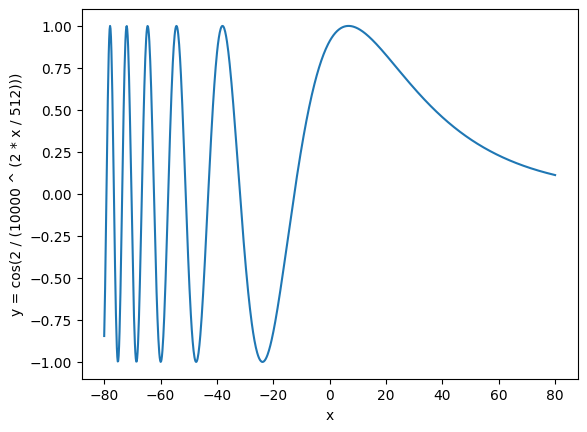

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Az x tengely beállítása
x = np.linspace(-80, 80, 1000)

# Az y tengely kiszámítása
y = np.sin(2 / (10000 ** (2 * x / 512)))

# A grafikon kirajzolása
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y = cos(2 / (10000 ^ (2 * x / 512)))")
plt.show()


Ha visszamegyünk az ebben a szakaszban elemzett mondathoz, láthatjuk, hogy a fekete a pos=2 pozícióban van, a barna pedig a pos=10 pozícióban:

In [ ]:
import math
import numpy as np

def positional_encoding(pos, pe):
    pe = pe.copy()  # create a copy to modify
    for i in range(0, 50, 2):
        pe[0][i] = math.sin(pos / (10000 ** ((2 * i) / 50)))
        pe[0][i+1] = math.cos(pos / (10000 ** ((2 * i) / 50)))
    return pe



In [ ]:
pos_2 = positional_encoding(2,np.zeros((1,50)))
pos_10 = positional_encoding(10, np.zeros((1,50)))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# Koszinusz hasonlóság számítása
similarity = cosine_similarity(pos_2, pos_10)

print("A koszinusz hasonlóság a '2' és '10' poziciók között:", similarity[0][0])


A koszinusz hasonlóság a '2' és '10' poziciók között: 0.8139628365202337


A pozíció kódolása alacsonyabb hasonlósági értéket mutat, mint a szóbeágyazási hasonlóság.A pozíciós kódolás szétválasztotta ezeket a szavakat.  A probléma most az, hogy hogyan adjuk hozzá a pozíciós kódolást a szóbeágyazási vektorokhoz.

Pozicionális kódolás hozzáadása a beágyazási vektorhoz
A Transformer szerzői egy egyszerű megoldást találtak: a pozicionális kódolási vektort egyszerűen hozzáadták a szóbeágyazási vektorhoz:

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file29.png)

In [ ]:
black_emb_pos = black_embedding*math.sqrt(50)+pos_2

In [ ]:
brown_emb_pos = brown_embedding*math.sqrt(50)+pos_10

In [ ]:
similarity = cosine_similarity(black_emb_pos, brown_emb_pos)
print("A koszinusz hasonlóság a 'black' és 'brown' szavak között a pozició kódolás után:", similarity[0][0])

A koszinusz hasonlóság a 'black' és 'brown' szavak között a pozició kódolás után: 0.8317626367297615


1. alréteg: Többfejű figyelem
A többfejű figyelem alréteg nyolc fejet tartalmaz, és a réteg utáni normalizálás következik, amely maradék (residual) kapcsolatokat ad az alréteg kimenetéhez, és normalizálja azt:

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file30.png)

*A kódoló blokk első rétegében található multi-attention (többfejű figyelem) alréteg bemenete egy olyan vektor, amely az egyes szavak beágyazását (embedding) és pozíciós kódolását tartalmazza. A blokk következő rétegei nem kezdik újra ezeket a műveleteket.*

*Egy bemeneti szekvencia minden egyes xn szavának vektora dmodel = 512 dimenziós: pe(xn) = [d1=9.09297407e-01, d2=-4.16146845e-01, .., d512=1.00000000e+00]*

*Az egyes xn szavak reprezentációja egy dmodel = 512 dimenziós vektorrá alakul.*

*Minden szót minden más szóhoz hozzárendelünk, hogy meghatározzuk, hogyan illeszkedik a szekvenciába. A következő mondatban láthatjuk, hogy a "rug" (szőnyeg) vagy a "cat" (macska) szavakkal állhat kapcsolatban:*

   Szekvencia = A macska ráült a szőnyegre, és kitisztíttatták.
   Sequence =The cat sat on the rug and it was dry-cleaned.

*A modell arra fog "tanulni", hogy meghatározza, a "rug" vagy a "cat" szóra vonatkozik-e az "it" (az) névmás. Ha a jelenlegi dmodel = 512 dimenziót használnánk fel, egy hatalmas számítást futtathatnánk. Ugyanakkor a szekvencia elemzésékor egyszerre csak egy szempontot kapnánk eredményül. Ráadásul más nézőpontok megtalálása is jelentős számítási időt igényelne.*


*Egy jobb megoldás az, ha a modell 8 feje az x szekvencia minden egyes xn szavának dmodel = 512 dimenzióját dk = 64 dimenzióba vetíti. Ezután a 8 fejet párhuzamosan futtathatjuk, hogy felgyorsítsuk az "edzési" folyamatot, és 8 különböző reprezentációs alteret kapjunk arra vonatkozóan, hogy az egyes szavak hogyan kapcsolódnak egymáshoz.*

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file31.png)

*Láthatjuk, hogy most 8 "fej" fut párhuzamosan. Például az egyik fej eldöntheti, hogy az "it" (az) névmás jól illeszkedik a "cat" (macska) szóhoz, egy másik, hogy jól illeszkedik a "rug" (szőnyeg) szóhoz, egy harmadik pedig, hogy a "rug" jól illeszkedik a  "dry-cleaned" (kitisztíttatták) kifejezéshez.*

*Az egyes fejek kimenete egy Zi mátrix, amelynek alakja x * dk. A multi-attention (többfejű figyelem) fej kimenete Z-vel van definiálva:*

Z = (Z0, Z1, Z2, Z3, Z4, Z5, Z6, Z7)

*Azonban Z-t össze kell fűzni ahhoz, hogy a többfejű figyelem alréteg kimenete ne egy dimenziósorozat legyen, hanem egy xm * dmodel mátrix egy sora.*

*A többfejű figyelem alrétegből való kilépés előtt Z elemeit összefűzzük:*

MultiHead(output) = Concat(Z0, Z1, Z2, Z3, Z4, Z5, Z6, Z7) = x, dmodel

*Megfigyelhető, hogy minden fej össze van fűzve z-be, amelynek dimenziója dmodel = 512. A többfejű réteg kimenete tiszteletben tartja az eredeti Transformer modell megszorításait.*

*A figyelem mechanizmus minden hn fején belül a "szó" mátrixoknak három reprezentációja van:*

   * Egy lekérdezési mátrix (Q), amelynek dimenziója dq = 64. Ez az összes többi "szó" mátrix kulcsérték párját keresi.
   * Egy kulcsmátrix (K) dk = 64 dimenzióval.
   * Egy érték mátrix (V) dv = 64 dimenzióval.

*A figyelem (attention) a következő egyenlet szerint definiálható, mint "Scaled Dot-Product Attention". Q, K és V értékeit behelyettesítjük:*

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file32.png)

*A mátrixok mindegyike azonos dimenzióval rendelkezik, így viszonylag egyszerű a mátrixműveletek (dot product) segítségével megkapni a figyelem értékeket az egyes fejekre, majd összefűzni a 8 fej Z kimenetét.*

*Q, K és V megszerzéséhez a modellt meg kell tanítani a hozzájuk tartozó Qw, Kw és Vw súlymátrixokkal, amelyekben dk = 64 oszlop és dmodel = 512 sor található. Például Q-t az x és Qw közötti ponttermékkel kapjuk meg. Q dimenziója dk = 64 lesz.*


**Fontosabb fogalmak:**

* **Scaled Dot-Product Attention:** A Transformer kulcsfontosságú összetevője. Ez határozza meg, hogy a bemeneti szekvencia egyes szavai mennyire relevánsak más szavakhoz képest.
* **Q, K, V mátrixok:** A "lekérdezés" (query), "kulcs" (key) és "érték" (value) mátrixok a figyelem mechanizmus bemenetei. Segítenek megtalálni a különböző szavak közötti összefüggéseket.
* **Súlymátrixok:** Ezek olyan tréningezhető paraméterek, amelyek a bemenetet Q, K és V ábrázolásokká alakítják át.



In [ ]:
import numpy as np
from scipy.special import softmax

print("Step 1: Input : 3 inputs, d_model=4")
x =np.array([[1.0, 0.0, 1.0, 0.0],   # Input 1
             [0.0, 2.0, 0.0, 2.0],   # Input 2
             [1.0, 1.0, 1.0, 1.0]])  # Input 3
print(x)

Step 1: Input : 3 inputs, d_model=4
[[1. 0. 1. 0.]
 [0. 2. 0. 2.]
 [1. 1. 1. 1.]]


**3 súlymátrixszal rendelkezünk:**

* **Qw:** a lekérdezések (query-k) tanítására
* **Kw:** a kulcsok (key-k) tanítására
* **Vw:** az értékek (value-k) tanítására

**Ezt a 3 súlymátrixot a modell összes bemenetére alkalmazzuk.**

**Vaswani et al. (2017) által leírt súlymátrixok mérete dK == 64.  Azonban itt a dK == 4 értékre kicsinyítjük őket.** A méretek 3x4-es súlymátrixokra vannak csökkentve, hogy az átmeneti eredményeket könnyebben lehessen megjeleníteni, és skaláris szorzatokat lehessen végrehajtani a bemenettel (x).

**A mátrixok mérete és alakja ebben az oktató példában önkényes. A cél az, hogy végigmenjünk a figyelem (attention) mechanizmus általános folyamatán.**

**A három súlymátrix a lekérdezések súlymátrixával (Qw) kezdődően kerül inicializálásra.**



In [ ]:
print("Step 2: weights 3 dimensions x d_model=4")
print("w_query")
w_query =np.array([[1, 0, 1],
                   [1, 0, 0],
                   [0, 0, 1],
                   [0, 1, 1]])
print(w_query)

Step 2: weights 3 dimensions x d_model=4
w_query
[[1 0 1]
 [1 0 0]
 [0 0 1]
 [0 1 1]]


In [ ]:
print("w_key")
w_key =np.array([[0, 0, 1],
                 [1, 1, 0],
                 [0, 1, 0],
                 [1, 1, 0]])
print(w_key)

w_key
[[0 0 1]
 [1 1 0]
 [0 1 0]
 [1 1 0]]


In [ ]:
print("w_value")
w_value = np.array([[0, 2, 0],
                    [0, 3, 0],
                    [1, 0, 3],
                    [1, 1, 0]])
print(w_value)

w_value
[[0 2 0]
 [0 3 0]
 [1 0 3]
 [1 1 0]]


![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file34.png)

**3. lépés: Mátrixszorzás a Q, K és V előállításához**

Most a bemeneti vektorokat megszorozzuk a súlymátrixokkal, hogy minden egyes bemenethez lekérdezési, kulcs- és értékvektort kapjunk.

Ebben a modellben feltételezzük, hogy az összes bemenethez egyetlen **w_query**, **w_key** és  **w_value** súlymátrix létezik. Más megközelítések is lehetségesek.

Először szorozzuk meg a bemeneti vektorokat a **w_query** súlymátrixszal:


In [ ]:
print("Step 3: Matrix multiplication to obtain Q,K,V")
print("Query: x * w_query")
Q=np.matmul(x,w_query)
print(Q)

Step 3: Matrix multiplication to obtain Q,K,V
Query: x * w_query
[[1. 0. 2.]
 [2. 2. 2.]
 [2. 1. 3.]]


In [ ]:
print("Key: x * w_key")
K=np.matmul(x,w_key)
print(K)

Key: x * w_key
[[0. 1. 1.]
 [4. 4. 0.]
 [2. 3. 1.]]


In [ ]:
print("Value: x * w_value")
V=np.matmul(x,w_value)
print(V)

Value: x * w_value
[[1. 2. 3.]
 [2. 8. 0.]
 [2. 6. 3.]]


![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file35.png)

A figyelemfej most az eredeti transzformer-egyenletet valósítja meg:

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file32.png)

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file36.png)

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file39.png)

In [ ]:
print("Step 4: Scaled Attention Scores")
k_d=1   #square root of k_d=3 rounded down to 1 for this example
attention_scores = (Q @ K.transpose())/k_d
print(attention_scores)

Step 4: Scaled Attention Scores
[[ 2.  4.  4.]
 [ 4. 16. 12.]
 [ 4. 12. 10.]]


![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file40.png)

Most egy softmax függvényt alkalmazunk minden egyes közbenső figyelempontszámra. Ahelyett, hogy mátrixszorzást végeznénk.

In [ ]:
print("Step 5: Scaled softmax attention_scores for each vector")
attention_scores[0]=softmax(attention_scores[0])
attention_scores[1]=softmax(attention_scores[1])
attention_scores[2]=softmax(attention_scores[2])
print(attention_scores[0])
print(attention_scores[1])
print(attention_scores[2])

Step 5: Scaled softmax attention_scores for each vector
[0.06337894 0.46831053 0.46831053]
[6.03366485e-06 9.82007865e-01 1.79861014e-02]
[2.95387223e-04 8.80536902e-01 1.19167711e-01]


![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file32.png)

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file41.png)

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file42.png)

In [ ]:
print("Step 6: attention value obtained by score1/k_d * V")
print(V[0])
print(V[1])
print(V[2])
print("Attention 1")
attention1=attention_scores[0].reshape(-1,1)
attention1=attention_scores[0][0]*V[0]
print(attention1)
print("Attention 2")
attention2=attention_scores[0][1]*V[1]
print(attention2)
print("Attention 3")
attention3=attention_scores[0][2]*V[2]
print(attention3)


Step 6: attention value obtained by score1/k_d * V
[1. 2. 3.]
[2. 8. 0.]
[2. 6. 3.]
Attention 1
[0.06337894 0.12675788 0.19013681]
Attention 2
[0.93662106 3.74648425 0.        ]
Attention 3
[0.93662106 2.80986319 1.40493159]


In [ ]:
print("Step 7: summed the results to create the first line of the output matrix")
attention_input1=attention1+attention2+attention3
print(attention_input1)

Step 7: summed the results to create the first line of the output matrix
[1.93662106 6.68310531 1.59506841]


A Transformer most az 1-7. lépésekben leírt eljárással határozhatja meg a 2. és 3. bemenet figyelmi értékeit (attention values), egyetlen "figyelmi fej" esetén (attention head).

![img](https://static.packt-cdn.com/products/9781805128724/graphics/media/file43.png)



9. Lépés: A "figyelmi fej"-einek (attention heads) eredménye

Feltételezzük, hogy betanítottuk az alréteg 8 "figyelmi fejét". A Transformernek így már 3 kimeneti vektora van (a 3 darab, szavakból vagy szórészletekből álló bemeneti vektorra) egyenként dmodel = 64 dimenzióval:

In [ ]:
z0h1=np.random.random((3, 64))
z1h2=np.random.random((3, 64))
z2h3=np.random.random((3, 64))
z3h4=np.random.random((3, 64))
z4h5=np.random.random((3, 64))
z5h6=np.random.random((3, 64))
z6h7=np.random.random((3, 64))
z7h8=np.random.random((3, 64))
print("shape of one head",z0h1.shape,"dimension of 8 heads",64*8)


shape of one head (3, 64) dimension of 8 heads 512


Ez azt jelenti, hogy minden "figyelmi fej" egy  (3, 64) alakú mátrixot generál eredményként. Mivel 8 fejünk van, összesen 512-es dimenziót kapunk (8 fej * 64 dimenzió fejenként)

A 8 "fej" létrehozta a  Z-t:
Z = (Z0, Z1, Z2, Z3, Z4, Z5, Z6, Z7)

A Transformer most összefűzi (konkatenálja) a Z 8 elemét a "több-fejes figyelem" (multi-head attention) alréteg végső kimenetére.

10. Lépés: A "fejek" kimenetének összefűzése

A Transformer összefűzi a Z  8 elemét:
MultiHead(Output) = Concat (Z0, Z1, Z2, Z3, Z4, Z5, Z6, Z7) W0 = x, dmodel

Fontos megjegyzés, hogy Z -t megszorozzuk W0-val, ami szintén egy tanított súlymátrix. Ebben a modellben feltételezzük, hogy W0 betanításra került, és beépítjük az összefűzési függvénybe (concatenation function).

A Z0-tól Z7-ig tehát összefűzésre kerülnek:

##**A BERT alapötlete**


A BERT a *Bidirectional Encoder Representation from Transformer* rövidítése, ami egy a Google által kiadott, korszerű nyelvi beágyazási modell. Jelentős áttörést jelentett az NLP (Natural Language Processing / természetes nyelvek feldolgozása) területén, mert sok olyan feladatban jobb eredményeket ért el, mint a kérdés-válaszolás, szöveggenerálás, mondatok osztályozása és még sok más. A BERT sikerének egyik fő oka, hogy ez egy kontextusalapú beágyazási modell, ellentétben más népszerű beágyazási modellekkel, például a word2vec-kel, amelyek kontextustól függetlenek.

Először is meg kell érteni, mi a különbség a kontextusalapú és a kontextustól független beágyazási modellek között. Vegyük a következő két mondatot:

**A mondat: Megmarta egy Python.**
**B mondat: A Python a kedvenc programozási nyelvem.**

A két mondatot olvasva megértjük, hogy a "Python" szó jelentése mindkét mondatban más. Az A mondatban a "Python" szó a kígyóra utal, míg a B mondatban a programozási nyelvre.

Ha a "Python" szó beágyazásait az előző két mondatban egy olyan beágyazási modell segítségével kapjuk meg, mint például a word2vec, akkor a "Python" szó beágyazása mindkét mondatban ugyanaz lesz, és ezáltal a "Python" szó jelentése mindkét mondatban ugyanaz lesz. Ennek az az oka, hogy a **word2vec a kontextustól független modell, ezért figyelmen kívül hagyja a kontextust, és mindig ugyanazt a beágyazást adja a "Python" szónak,** függetlenül a kontextustól.

**A BERT ezzel szemben kontextusalapú modell. Megéti a kontextust, majd a kontextus alapján generálja a szó beágyazását. Tehát az előző két mondatra a kontextustól függően különböző beágyazásokat ad a "Python" szóra.** De hogyan működik ez? Hogyan érti meg a BERT a kontextust? Vizsgáljuk meg ezt részletesebben.

Vegyük az A mondatot: Megmarta egy Python.  Először is, a BERT a mondat minden egyes szavát a mondat összes többi szavához kapcsolja, hogy minden szó kontextuális jelentését megértse. Tehát, hogy megértse a "Python" szó kontextuális jelentését, a BERT a "Python" szót veszi, és a mondat összes szavához kapcsolja. Így a BERT a "megmarta" szó használata révén megértheti, hogy az A mondatban a "Python" szó a kígyót jelöli.  

#**Hogyan működik a BERT**

A Bidirectional Encoder Representation from Transformer (BERT), ahogy a neve is sugallja, a Transformer modellen alapul. A BERT-et úgy foghatjuk fel, mint a Transformert, de csak az enkóder (kódoló) résszel.

**A Transformer enkódere kétirányú, mivel mindkét irányban képes egy mondatot olvasni.** Így a BERT alapvetően egy *Bidirectional Encoder Representation* a Transformerből származtatva.

Értsük meg egy példa segítségével, hogyan működik BERT mint kétirányú enkóder-reprezentáció. Vegyük ugyanazokat a mondatokat, amelyeket az előző részben láttunk.

Tegyük fel, hogy az A mondatunk: "Megmarta egy Python". Ezt a mondatot bemenetként adjuk a Transformer enkóderének, és kimenetként megkapjuk a mondatban szereplő egyes szavak kontextuális reprezentációját (beágyazását). Miután a mondatot bemenetként adjuk az enkódernek, az a "multi-head" figyelemmechanizmus használatával megérti az egyes szavak jelentését a mondatban (minden szót összekapcsol a mondat összes többi szavával, hogy megértse a szavak közötti viszonyt és kontextuális jelentését). Kimenete a mondatban szereplő egyes szavak kontextuális reprezentációja.

Ahogy az alábbi ábrán látható, a mondatot betápláljuk a Transformer enkóderébe, és a kimenetben megkapjuk a mondat minden szavának reprezentációját. Akár N számú enkódert egymásra építhetünk, ahogy azt az alábbi ábra is mutatja. A könnyebb érthetőség kedvéért csak az első enkóder van kibontva. Az ábrán a  jelöli a "Megmarta" szó reprezentációját,  az "egy" szóét, és így tovább. Minden szó reprezentációjának mérete megegyezik az enkóder réteg méretével. Ha az enkóder réteg mérete 768, akkor minden egyes szó reprezentációja is 768 elemű lesz:


![img](https://static.packt-cdn.com/products/9781838821593/graphics/assets/0f9c7586-df6f-48b4-a4d1-0a4c2d1cd222.png)

Bert-tiny
Bert-mini
Bert-small
Bert-medium L=12 A=12 H=768
Bert-large L=24 A=16 H=1024

![img](https://static.packt-cdn.com/products/9781838821593/graphics/assets/58f2bf68-0189-4cbe-b957-333f971a812f.png)

##**Előtréning stratégiák**

A BERT modellt a következő két feladatra tréningelik (előkészítik):

* **Maszkolt nyelvi modellezés**
* **Következő mondat előrejelzése**

Értsük meg, hogyan működik ez a két előtréning módszer! Kezdjük a maszkolt nyelvi modellezéssel, de előtte nézzük meg röviden, a nyelvi modellezés alapjait.

**Nyelvi modellezés**

A nyelvi modellezési feladatban a modellt arra képezzük ki, hogy egy adott szó sorozat alapján megjósolja a következő szót. Két alapvető fajtája van:

* **Autoregresszív nyelvi modellezés**
* **Auto-encoding nyelvi modellezés**

**Autoregresszív nyelvi modellezés**

Két iránya lehet:

* *Előrejelzés balról jobbra*
* *Előrejelzés jobbról balra*

Nézzünk egy példát! Vegyük ezt a szöveget: _"Párizs egy gyönyörű város. Szeretem Párizst."_ Távolítsuk el a "város" szót és tegyünk a helyére egy üres helyet:

_Párizs egy gyönyörű __. Szeretem Párizst_

A modellnek ki kell találnia, mi kerül az üres helyre. Ha balról-jobbra előrejelzést használunk, a modell balról jobbra olvassa az összes szót a kihagyásig, így próbálva meghatározni a hiányzó szót.

Ha jobbról-balra előrejelzést használunk, akkor ennek megfelelően fordított irányban fog olvasni.

Az autoregresszív modellek tehát egyirányúak, csak az egyik irányban olvassák a mondatot.

**Auto-encoding nyelvi modellezés**

Ezek a modellek mindkét irányt (balról jobbra és jobbról balra) használják. Azaz, az előrejelzéskor mindkét irányban elolvassák a mondatot. Ezzel azt mondhatjuk, hogy a modelljük kétirányú. Nézzük, hogy működik ez, miközben megpróbálja meghatározni a kihagyott szót:

_Párizs egy gyönyörű __. Szeretem Párizst_

A kétirányú modell jobb eredményt ad, mert ha mindkét irányból olvassuk a mondatot, az segít jobban megérteni a jelentését.

Most, hogy megértettük a nyelvi modellezés működését, nézzük át a BERT egyik előtréning stratégiáját, az úgynevezett maszkolt nyelvi modellezést.

**Maszkolt nyelvi modellezés**

A BERT auto-encoding nyelvi modell, azaz mindkét irányban olvassa a mondatot az előrejelzésekhez. A maszkolt nyelvi modellezési feladatban egy adott bemeneti mondatban a szavak 15%-át véletlenszerűen elfedjük (maszkoljuk), és a hálózatot arra képezzük ki, hogy jósolja meg ezeket az eltakart szavakat.  Ehhez a modellünk mindkét irányban elolvassa a mondatot, és megpróbálja kitalálni, mi lehetett ott.




![img](https://static.packt-cdn.com/products/9781838821593/graphics/assets/869e2319-4032-4b4e-b3f9-1c559cdcfbfb.png)

##**Következő mondat előrejelzése**

A "Next Sentence Prediction" (NSP), vagyis a "következő mondat előrejelzése" egy másik érdekes stratégia a BERT modell tréningjére. Az NSP egy bináris osztályozási feladat, azaz kétféle eredménye lehet. Ebben a feladatban két mondatot adunk inputként a BERT-nek, aminek el kell döntenie, hogy a második mondat folytatása-e az első mondatnak.

Nézzük, hogyan működik ez a gyakorlatban:

1. mondat: Főtt tésztát ettem vacsorára.
2. mondat: Nagyon finom volt.

Az első mondat után a második mondat logikus folytatás, ezért ezt a párt az _"isNext"_ címkével látjuk el (magyarul kb. "következő").

Másik példa:

1. mondat: Bekapcsolta a rádiót.
2. mondat: Vettem egy új sapkát.

Ez esetben a két mondatnak semmi köze egymáshoz, ezért ezt a párt a _"notNext"_ (nem következő) címkével látjuk el.

Az NSP feladatban a modellünknek az a célja, hogy eldöntse, egy adott mondatpár "következő" vagy "nem következő" kategóriába tartozik-e.  A két mondatot együtt adjuk meg a BERT-nek inputként, és arra képezzük ki, hogy képes legyen helyesen meghatározni a kapcsolatukat.  Ha a második mondat az első folytatása, _"isNext"_ eredményt ad, különben _"notNext"-ot. Ez tehát egy igen/nem típusú osztályozási feladat.

De mire is jó ez az NSP feladat? Azzal, hogy a modell megtanulja felismerni a mondatok közötti kapcsolatot, sok más nyelvi feladatban válik hasznossá. A kérdés-megválaszolás vagy a szöveggenerálás például sokszor igénylik, hogy a szöveg összefüggéseit helyesen modellezzük.

Rendben, de honnan szerezhetünk adatot ehhez a feladathoz? Bármely egynyelvű szöveges gyűjteményből (korpuszból) létrehozhatunk ilyet. Az "isNext" kategóriára veszünk egy dokumentumot és az egymást követő mondatokat ezzel a címkével látjuk el.  A "notNext" kategóriához különböző dokumentumokból veszünk véletlenszerűen mondatokat, így azok nem fognak összefüggeni. Fontos, hogy az adatok 50%-a az egyik, a másik 50%-a a másik kategóriába essen.

![img](https://static.packt-cdn.com/products/9781838821593/graphics/assets/9267cac4-dccb-4c21-b4e9-18e660757018.png)


In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

outputs = model(**inputs) #(kettős csillag) operátor kibontja az inputs szótár tartalmát kulcs-érték párokká, és ezeket argumentumként adja át a model konstruktornak.
print(outputs.last_hidden_state.shape)
outputs

torch.Size([1, 16, 768])


BaseModelOutput(last_hidden_state=tensor([[[-0.1798,  0.2333,  0.6321,  ..., -0.3017,  0.5008,  0.1481],
         [ 0.2758,  0.6497,  0.3200,  ..., -0.0760,  0.5136,  0.1329],
         [ 0.9046,  0.0985,  0.2950,  ...,  0.3352, -0.1407, -0.6464],
         ...,
         [ 0.1466,  0.5661,  0.3235,  ..., -0.3376,  0.5100, -0.0561],
         [ 0.7500,  0.0487,  0.1738,  ...,  0.4684,  0.0030, -0.6084],
         [ 0.0519,  0.3729,  0.5223,  ...,  0.3584,  0.6500, -0.3883]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)